# Comparing weightings on a same underlying graph by the symmetric difference metric over an edge-filtration.


Import libraries:

In [1]:
from random import seed, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bisect import bisect_left
seed(666)

Define a random hypercube of dimension $n$ with edges not sorted if `bias=0`, edges sorted in descending order if `bias=1`, or edges sorted in ascending order if `bias=2`. Graphs, like these random hypercubes, are lists of tuples (start vertex, end vertex, weight) corresponding to edges.

In [2]:
def randcube(n,bias=0):
    graph = []
    for source in range(2**n):
        targets = set(range(n)) - set(i for i, digit in enumerate(reversed((bin(source)))) if digit == '1')
        randomlist = [random() for i in targets]
        weights = [float(k)/sum(randomlist) for k in randomlist]
        if bias == 1:
            weights.sort(reverse=True) 
        if bias == 2:
            weights.sort(reverse=False) 
        for i,t in enumerate(targets):
            graph.append((source,source+2**t,weights[i]))
    return graph

Define the null hypercube of dimension $n$, where the weights are uniform, i.e, equal for outgoing edges summing one. 

In [3]:
def null_cube(n):
    graph = []
    for source in range(2**n):
        targets = set(range(n)) - set(i for i, digit in enumerate(reversed((bin(source)))) if digit == '1')
        for t in targets:
            graph.append((source, source+2**t,1/len(targets)))
    return graph

Define a function to transform probability weights into flux weights, and a function to transform flux weights into probability weights.

In [4]:
def prob_to_flux(graph,already_sorted = True):
    if not already_sorted:
        graph = sorted(graph)
    nodeWeights, nodeInflux, newGraph = (dict(),dict(),list())
    node = graph[0][0]
    nodeWeights[node] = 1
    for edge in graph:
        if edge[0] != node:
            node = edge[0]
            nodeWeights = {node:nodeInflux[node]}
        flux = nodeWeights[node]*edge[2]
        newGraph.append((edge[0],edge[1],flux))
        if edge[1] not in nodeInflux.keys():
            nodeInflux[edge[1]] = flux
        else:
            nodeInflux[edge[1]] = nodeInflux[edge[1]] + flux
    return newGraph

def flux_to_prob(graph,already_sorted = True):
    nodeOutflux = dict()
    for edge in graph:
        if edge[0] not in nodeOutflux.keys():
            nodeOutflux[edge[0]] = edge[2]
        else:
            nodeOutflux[edge[0]] = nodeOutflux[edge[0]] + edge[2]
    return [(e[0],e[1],e[2]/nodeOutflux[e[0]]) for e in graph]

Define a function to open the .csv of .txt files of the outputs of HyperHMM or HyperTraPS with columns: Start vertex | End vertex | Weight. The output is graphs.

In [5]:
def impor(file):
    data = open(file).read().split('\n')
    data.pop(0)
    while data[-1]=='':
        data.pop(-1)
    for i,d in enumerate(data):
        a,b,c = d.split()
        data[i]=(int(a),int(b),float(c))
    return data

# $l_1$-metric between the weightings corresponding to the area under the curve from WFCC

For two given graphs, define the $l_1$-metric of their weightings (named `area`). If edges of the graphs need to be sorted, i.e. the edges apprear in different position, let `sort = True`. If the graphs have non-common edges, let `complete = True` to add the missing edges in the corresponding graphs with weight 0.

In [6]:
def complete_edges(g0,g1):
    commonedges = set([(e[0],e[1],0) for e in g0+g1])
    c0 = list(commonedges - set([(e[0],e[1],0) for e in g0]))
    c1 = list(commonedges - set([(e[0],e[1],0) for e in g1]))
    return (g0 + c0,g1 + c1)

def area(g0, g1, sort=False, complete=False):
    if complete:
        g0, g1 = complete_edges(g0,g1)
    if sort:
        g0.sort(key=lambda x: (x[0], x[1]))
        g1.sort(key=lambda x: (x[0], x[1]))
    return sum([abs(w-g1[i][2]) for i,(s,t,w) in enumerate(g0)])

# Weight-Filtration Comparison Curve (WFCC)

The WFCC computes the symmetric difference metric for each filtration value, producing a curve. We assume that the graphs given as input have the same edges. If the edges might appear in different order for the two graphs set `sort = True`, to sort them. If the graphs do not have the same edges, set `complete = True` to add missing edges with weight 0. The `fVals` is either a list of filtration values for which we compute the symmetric difference or an integer giving equally spaced values in the interval from 0 to the maximum weight. This function outputs an array of filtration values and a list of corresponding values of the cardinality of the symmetric difference. 

In [7]:
def WFCC(g0,g1, fVals = 1000, sort=False, complete = False):
    if complete:
        g0, g1 = complete_edges(g0,g1)
        sort = True
    if sort:
        g0.sort(key=lambda x: (x[0], x[1]))
        g1.sort(key=lambda x: (x[0], x[1]))
    
    merged = [(min(w,g1[i][2]),max(w,g1[i][2])) for i,(s,t,w) in enumerate(g0)]
    try:
        sCard = [0 for _ in fVals]
        fVals = np.array(fVals)
    except:
        sCard = [0 for _ in range(fVals)]
        fVals = np.linspace(0, max(d for (_,d) in merged), fVals)
        
    for p0,p1 in merged:
        i = bisect_left(fVals,p0)
        while fVals[i]<p1:
            if fVals[i]<=p0:
                i += 1
                continue
            sCard[i] += 1
            i += 1
    return (fVals,sCard)

Next, we define a function to visualise the WFCC comparison of a graph with several (a list of) other graphs. The output is the plot of the curves, and for convenience, we also print the areas under the curves.

The inputs are:
- g0: a graph to compare againts the others as a list of tuples (start vertex, end vertex, weight) corresponding to edges
- g1: list of graphs to compare each one against g0
- label_g0: name of the graph g0, as a string, for the title of the plot
- labels_g1: list of names of the graphs in g1, as strings, for the legend
- colors: list of colors, as strings, one for each graph in g1
- log: True or False, it returns the plot in logarithmic scale if True
- fVals: integer giving the resolution of the filtration value, or a list of filtration values to consider 
- sort: True or False, it sorts the order of the edges of the input graphs if True
- complete: True or False, it completes graphs by adding missing edges with weight 0. 

In [8]:
def WFCCplot(g0, g1, label_g0, labels_g1, colors, log, fVals = 1000, sort=False, complete = False): 
    x,y = ([],[])
    for g in g1:
        x_val,y_val = WFCC(g0,g,fVals = fVals,sort=sort, complete=complete)
        x.append(x_val)
        y.append(y_val)
    fig,ax = plt.subplots(figsize=(6,5))
    for i in range(0, len(x)):
        plt.plot(x[i],y[i], label=labels_g1[i], c=colors[i])
    plt.title(label_g0 + " compared to:", fontsize=15)
    plt.xlabel("Filtration value", fontsize=13)
    plt.ylabel("Cardinality of symmetric difference", fontsize=13)
    plt.legend(loc='best', fontsize=13)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)
    if log==True:
        plt.yscale('log')
    plt.savefig('./Data_files_hypercubes/Outputs_github/'+label_g0+'_vs.png')
    plt.show()
    for i in range(0, len(x)):
        print("The area under the curve for "+label_g0+" vs "+labels_g1[i]+" is: ", area(g0,g1[i],sort,complete))

# Results

# 1. WFCC comparison of synthetic hypercubes for probability weightings



Open the csv file of the synthetic hypercubes and their probability and flux weights:

In [9]:
data=pd.read_csv('./Data_files_hypercubes/diff-cubes.csv')
data.head()

,From,To,P,F,label
0,0,1,0.333333,0.333333,Null
1,0,2,0.333333,0.333333,Null
2,0,4,0.333333,0.333333,Null
3,1,3,0.500000,0.166667,Null
4,1,5,0.500000,0.166667,Null


Select data for probability weightings:

In [10]:
labs = list(set(data["label"]))

dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab].drop(columns=['F','label']))

dfs_p=[]
for d in dfs:
    dfs_p.append(d.to_numpy())

Due to the overlap of curves for our examples, instead of calling the fucntion WFCC, we manually generate the plots to adapt the width and style of the curves.

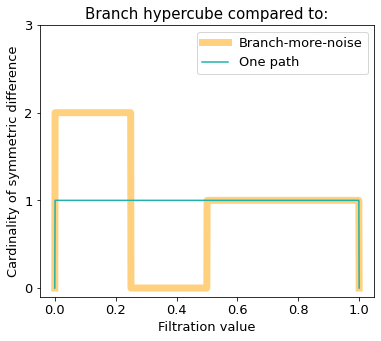

The area under the curve for Branch vs Branch-more-noise is:  1.0
The area under the curve for Branch vs One path is:  1.0


In [11]:
x_val1,y_val1 = WFCC(dfs_p[labs.index('Branch')], dfs_p[labs.index('Branch-more-noise')])

x_val2,y_val2 = WFCC(dfs_p[labs.index('Branch')], dfs_p[labs.index('One path')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'orange', linewidth=7, alpha=0.5)
plt.plot(x_val2,y_val2, 'lightseagreen', linewidth=1.5)

plt.title('Branch hypercube compared to:', fontsize=15)
plt.legend(['Branch-more-noise','One path'], fontsize=13)
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)   
plt.yticks([0,1,2,3])
plt.savefig('./Data_files_hypercubes/Outputs_github/samearea_diffplots.png')
plt.show()

print('The area under the curve for Branch vs Branch-more-noise is: ', area(dfs_p[labs.index('Branch')],dfs_p[labs.index('Branch-more-noise')]))
print('The area under the curve for Branch vs One path is: ', area(dfs_p[labs.index('Branch')],dfs_p[labs.index('One path')]))

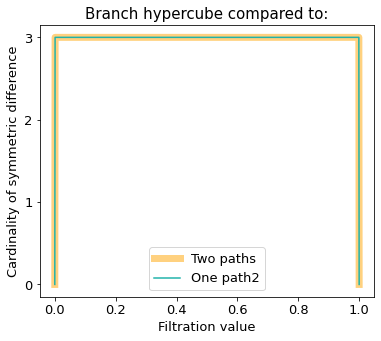

The area under the curve for Branch vs Two paths is: 3.0
The area under the curve for Branch vs One path2: 3.0


In [12]:
x_val1,y_val1 = WFCC(dfs_p[labs.index('Branch')], dfs_p[labs.index('Two paths')])

x_val2,y_val2 = WFCC(dfs_p[labs.index('Branch')], dfs_p[labs.index('One path2')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'orange', linewidth=7, alpha=0.5)
plt.plot(x_val2,y_val2, 'lightseagreen', linewidth=1.5)

plt.title('Branch hypercube compared to:', fontsize=15)
plt.legend(['Two paths','One path2'], fontsize=13)
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13) 
plt.yticks([0,1,2,3])
plt.savefig('./Data_files_hypercubes/Outputs_github/samearea_sameplots.png')
plt.show()

print('The area under the curve for Branch vs Two paths is:', area(dfs_p[labs.index('Branch')], dfs_p[labs.index('Two paths')]))
print('The area under the curve for Branch vs One path2:', area(dfs_p[labs.index('Branch')], dfs_p[labs.index('One path2')]))

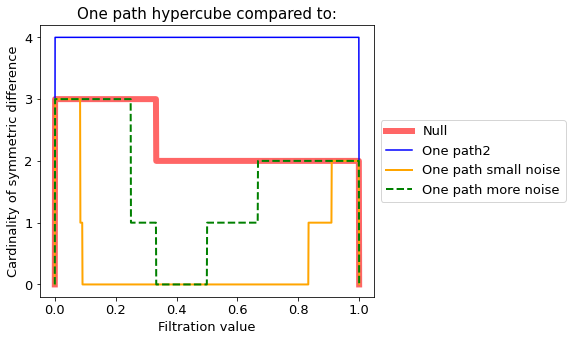

The area under the curve for One path vs null is:  2.333333333333333
The area under the curve for One path vs One path2 is:  4.0
The area under the curve for One path vs One path-small-noise is:  0.5151515151515156
The area under the curve for One path vs One path-more-noise is:  1.666666666666666


In [13]:
x_val1,y_val1 = WFCC(dfs_p[labs.index('One path')], dfs_p[labs.index('Null')])

x_val2,y_val2 = WFCC(dfs_p[labs.index('One path')], dfs_p[labs.index('One path2')])

x_val3,y_val3 = WFCC(dfs_p[labs.index('One path')], dfs_p[labs.index('One path-small-noise')])

x_val4,y_val4 = WFCC(dfs_p[labs.index('One path')], dfs_p[labs.index('One path-more-noise')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'red', linewidth=6, alpha=0.6)
plt.plot(x_val2,y_val2, 'blue', linewidth=1.5)
plt.plot(x_val3,y_val3, 'orange', linewidth=2)
plt.plot(x_val4,y_val4, 'green', linewidth=2, linestyle='--', zorder=5 )

plt.title('One path hypercube compared to:', fontsize=15)
plt.legend(['Null','One path2', 'One path small noise', 'One path more noise', 'Two paths', 'Branch'], fontsize=13, bbox_to_anchor=(1, 0.5), loc="center left")
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)
plt.savefig('./Data_files_hypercubes/Outputs_github/onepathvs.png', bbox_inches='tight')
plt.yticks([0,1,2,3,4])
plt.show()

print('The area under the curve for One path vs null is: ', area(dfs_p[labs.index('One path')], dfs_p[labs.index('Null')]))
print('The area under the curve for One path vs One path2 is: ', area(dfs_p[labs.index('One path')],dfs_p[labs.index('One path2')]))
print('The area under the curve for One path vs One path-small-noise is: ', area(dfs_p[labs.index('One path')],dfs_p[labs.index('One path-small-noise')]))
print('The area under the curve for One path vs One path-more-noise is: ', area(dfs_p[labs.index('One path')],dfs_p[labs.index('One path-more-noise')]))

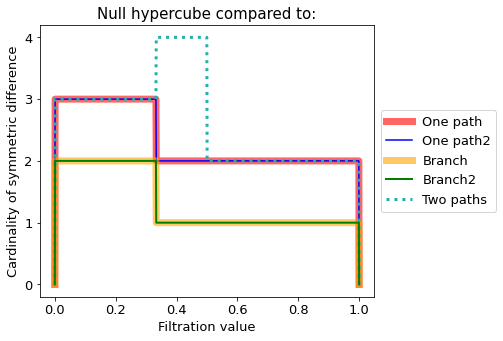

The area under the curve for Null vs One path is:  2.333333333333333
The area under the curve for Null vs One path2 is:  2.333333333333333
The area under the curve for Null vs Branch is:  1.333333333333333
The area under the curve for Null vs Branch2 is:  1.333333333333333
The area under the curve for Null vs Two paths is 2.666666666666667


In [14]:
x_val1,y_val1 = WFCC(dfs_p[labs.index('Null')], dfs_p[labs.index('One path')])

x_val2,y_val2 = WFCC(dfs_p[labs.index('Null')], dfs_p[labs.index('One path2')])

x_val3,y_val3 = WFCC(dfs_p[labs.index('Null')], dfs_p[labs.index('Branch')])

x_val4,y_val4 = WFCC(dfs_p[labs.index('Null')], dfs_p[labs.index('Branch2')])

x_val5,y_val5 = WFCC(dfs_p[labs.index('Null')], dfs_p[labs.index('Two paths')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'red', linewidth=7, alpha=0.6)
plt.plot(x_val2,y_val2, 'blue', linewidth=1.5 )
plt.plot(x_val3,y_val3, 'orange', linewidth=7, alpha=0.6)
plt.plot(x_val4,y_val4, 'green', linewidth=2, zorder=3 )
plt.plot(x_val5,y_val5, 'lightseagreen', linewidth=3, linestyle=':')

plt.title('Null hypercube compared to:', fontsize=15)
plt.legend(['One path','One path2','Branch','Branch2', 'Two paths'], fontsize=13, bbox_to_anchor=(1, 0.5), loc="center left")
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)
plt.yticks([0,1,2,3,4])
plt.savefig('./Data_files_hypercubes/Outputs_github/nullvs.png', bbox_inches='tight')
plt.show()

print('The area under the curve for Null vs One path is: ', area(dfs_p[labs.index('Null')],dfs_p[labs.index('One path')]))
print('The area under the curve for Null vs One path2 is: ', area(dfs_p[labs.index('Null')],dfs_p[labs.index('One path2')]))
print('The area under the curve for Null vs Branch is: ', area(dfs_p[labs.index('Null')],dfs_p[labs.index('Branch')]))
print('The area under the curve for Null vs Branch2 is: ', area(dfs_p[labs.index('Null')],dfs_p[labs.index('Branch2')]))
print('The area under the curve for Null vs Two paths is', area(dfs_p[labs.index('Null')],dfs_p[labs.index('Two paths')]))

Distance matrix of the areas under the curves for each pair in the synthetic hypercubes dataset. This matrix is saved as a csv file for further use in the MDS code in R.

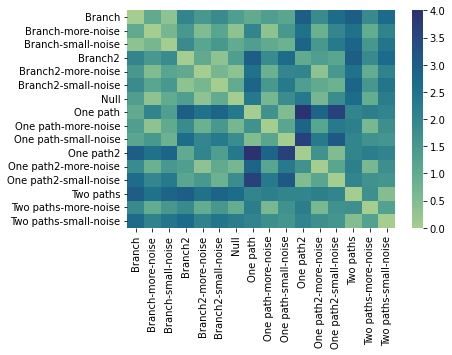

In [15]:
labs = list(set(data["label"]))
dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab])
for i,d in enumerate(dfs):
    d = d.drop(columns=['F','label'])
    dfs[i] = list(d.itertuples(index=False, name=None))
    
D = np.zeros((len(labs),len(labs)))
for i in range(len(labs)):
    for j in range(len(labs)):
        D[i][j] = area(dfs[i],dfs[j])
        
Ddf = pd.DataFrame(D)
Ddf.columns = labs
Ddf.index = labs
Ddf = Ddf.reindex(sorted(Ddf.columns), axis=1)
Ddf = Ddf.reindex(sorted(Ddf.index), axis=0)

sns_plot=sns.heatmap(Ddf, annot=False,cmap="crest")
fig = sns_plot.get_figure()
fig.savefig('./Data_files_hypercubes/Outputs_github/Distance_matrix_probability.png')

Ddf.to_csv('./Data_files_hypercubes/Outputs_github/Distance_matrix_probability.csv') 

Comparison of random hypercubes.


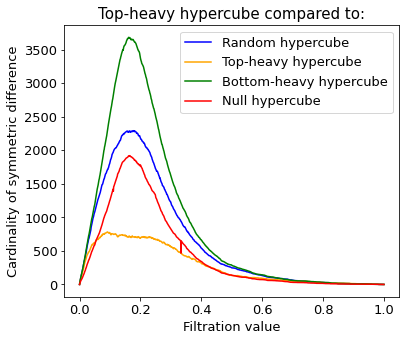

The area under the curve for Top-heavy hypercube vs Random hypercube is:  647.2378234794922
The area under the curve for Top-heavy hypercube vs Top-heavy hypercube is:  284.05277046514584
The area under the curve for Top-heavy hypercube vs Bottom-heavy hypercube is:  897.2783595966262
The area under the curve for Top-heavy hypercube vs Null hypercube is:  459.7772881532037


In [16]:
n = 10

g0 = randcube(n,bias = 1)
g1_1 = randcube(n,bias = 0)
g1_2 = randcube(n,bias = 1)
g1_3 = randcube(n,bias = 2)
g1_4 = null_cube(n)

g1=[g1_1, g1_2, g1_3, g1_4]
label_g0='Top-heavy hypercube'
labels_g1=['Random hypercube','Top-heavy hypercube','Bottom-heavy hypercube','Null hypercube']
colors=['blue', 'orange', 'green', 'red']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

# 2. WFCC comparison of synthetic hypercubes for flux weightings



Select data for flux weightings:

In [17]:
labs = list(set(data["label"]))
dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab].drop(columns=['P','label']))

dfs_f=[]
for d in dfs:
    dfs_f.append(d.to_numpy())

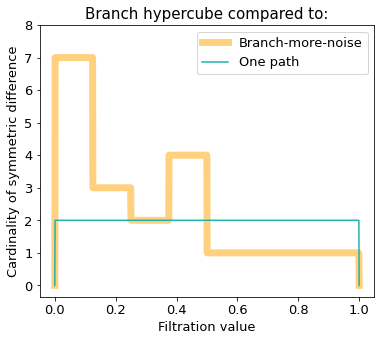

The area under the curve for Branch vs Branch-more-noise is:  2.5
The area under the curve for Branch vs One path is:  2.0


In [18]:
x_val1,y_val1 = WFCC(dfs_f[labs.index('Branch')], dfs_f[labs.index('Branch-more-noise')])

x_val2,y_val2 = WFCC(dfs_f[labs.index('Branch')], dfs_f[labs.index('One path')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'orange', linewidth=7, alpha=0.5)
plt.plot(x_val2,y_val2, 'lightseagreen', linewidth=1.5)

plt.title('Branch hypercube compared to:', fontsize=15)
plt.legend(['Branch-more-noise','One path'], fontsize=13)
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)   
plt.yticks([0,1,2,3, 4, 5, 6, 7 ,8])
plt.savefig('./Data_files_hypercubes/Outputs_github/samearea_diffplots_flux.png')
plt.show()

print('The area under the curve for Branch vs Branch-more-noise is: ', area(dfs_f[labs.index('Branch')],dfs_f[labs.index('Branch-more-noise')]))
print('The area under the curve for Branch vs One path is: ', area(dfs_f[labs.index('Branch')],dfs_f[labs.index('One path')]))

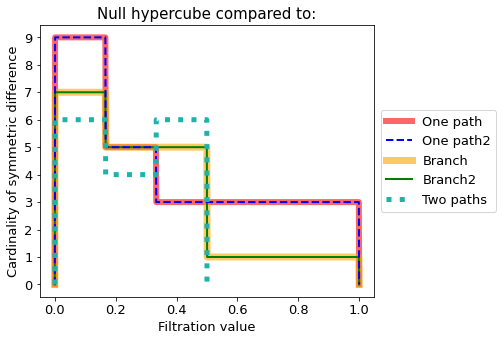

The area under the curve for Null vs One path is:  4.333333333333334
The area under the curve for Null vs One path2 is:  4.333333333333334
The area under the curve for Null vs Branch is:  3.333333333333334
The area under the curve for Null vs Branch2 is:  3.333333333333334
The area under the curve for Null vs Two paths is 2.666666666666668


In [19]:
x_val1,y_val1 = WFCC(dfs_f[labs.index('Null')], dfs_f[labs.index('One path')])

x_val2,y_val2 = WFCC(dfs_f[labs.index('Null')], dfs_f[labs.index('One path2')])

x_val3,y_val3 = WFCC(dfs_f[labs.index('Null')], dfs_f[labs.index('Branch')])

x_val4,y_val4 = WFCC(dfs_f[labs.index('Null')], dfs_f[labs.index('Branch2')])

x_val5,y_val5 = WFCC(dfs_f[labs.index('Null')], dfs_f[labs.index('Two paths')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'red', linewidth=6, alpha=0.6)
plt.plot(x_val2,y_val2, 'blue', linewidth=2, linestyle='--', zorder=3)
plt.plot(x_val3,y_val3, 'orange', linewidth=7, alpha=0.6)
plt.plot(x_val4,y_val4, 'green', linewidth=2, zorder=2)
plt.plot(x_val5,y_val5, 'lightseagreen', linewidth=5, linestyle=':', zorder=6)


plt.title('Null hypercube compared to:', fontsize=15)
plt.legend(['One path','One path2','Branch','Branch2', 'Two paths'], fontsize=13, bbox_to_anchor=(1, 0.5), loc="center left")
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)   
plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.savefig('./Data_files_hypercubes/Outputs_github/nullvs_flux.png', bbox_inches='tight')
plt.show()

print('The area under the curve for Null vs One path is: ', area(dfs_f[labs.index('Null')],dfs_f[labs.index('One path')]))
print('The area under the curve for Null vs One path2 is: ', area(dfs_f[labs.index('Null')],dfs_f[labs.index('One path2')]))
print('The area under the curve for Null vs Branch is: ', area(dfs_f[labs.index('Null')],dfs_f[labs.index('Branch')]))
print('The area under the curve for Null vs Branch2 is: ', area(dfs_f[labs.index('Null')],dfs_f[labs.index('Branch2')]))
print('The area under the curve for Null vs Two paths is', area(dfs_f[labs.index('Null')],dfs_f[labs.index('Two paths')]))

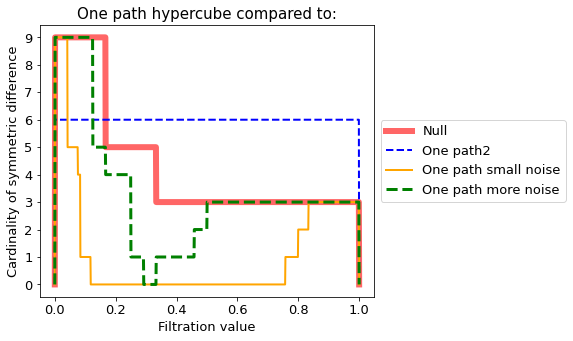

The area under the curve for One path vs Null is:  4.333333333333334
The area under the curve for One path vs One path2 is:  6.0
The area under the curve for One path vs One path-small-noise is:  1.2196969696969697
The area under the curve for One path vs One path-more-noise is:  3.416666666666668


In [20]:
x_val1,y_val1 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('Null')])

x_val2,y_val2 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('One path2')])

x_val3,y_val3 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('One path-small-noise')])

x_val4,y_val4 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('One path-more-noise')])

x_val5,y_val5 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('Two paths')])

x_val6,y_val6 = WFCC(dfs_f[labs.index('One path')], dfs_f[labs.index('Branch')])

fig,ax = plt.subplots(figsize=(6,5))

plt.plot(x_val1,y_val1, 'red', linewidth=6, alpha=0.6)
plt.plot(x_val2,y_val2, 'blue', linewidth=2, linestyle='--')
plt.plot(x_val3,y_val3, 'orange', linewidth=2)
plt.plot(x_val4,y_val4, 'green', linewidth=3, linestyle='--', zorder=6)


plt.title('One path hypercube compared to:', fontsize=15)
plt.legend(['Null','One path2', 'One path small noise', 'One path more noise', 'Two paths', 'Branch'], fontsize=13, bbox_to_anchor=(1, 0.5), loc="center left")
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)

plt.savefig('./Data_files_hypercubes/Outputs_github/onepathvs_flux.png', bbox_inches='tight')
plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

print('The area under the curve for One path vs Null is: ', area(dfs_f[labs.index('One path')], dfs_f[labs.index('Null')]))
print('The area under the curve for One path vs One path2 is: ', area(dfs_f[labs.index('One path')],dfs_f[labs.index('One path2')]))
print('The area under the curve for One path vs One path-small-noise is: ', area(dfs_f[labs.index('One path')],dfs_f[labs.index('One path-small-noise')]))
print('The area under the curve for One path vs One path-more-noise is: ', area(dfs_f[labs.index('One path')],dfs_f[labs.index('One path-more-noise')]))


Distance matrix of the areas under the curves for each pair in the synthetic hypercubes dataset. This matrix is saved as a csv file for further use in the MDS code in R.

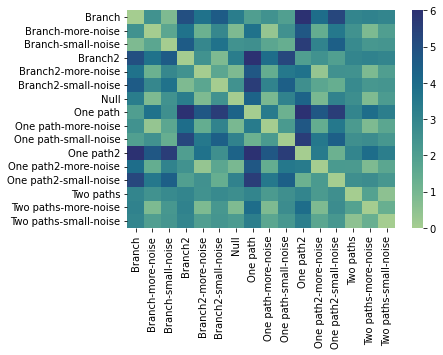

In [21]:
labs = list(set(data["label"]))
dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab])
for i,d in enumerate(dfs):
    d = d.drop(columns=['P','label'])
    dfs[i] = list(d.itertuples(index=False, name=None))
    
D = np.zeros((len(labs),len(labs)))
for i in range(len(labs)):
    for j in range(len(labs)):
        D[i][j] = area(dfs[i],dfs[j])
        
Ddf = pd.DataFrame(D)
Ddf.columns = labs
Ddf.index = labs
Ddf = Ddf.reindex(sorted(Ddf.columns), axis=1)
Ddf = Ddf.reindex(sorted(Ddf.index), axis=0)

sns_plot=sns.heatmap(Ddf, annot=False,cmap="crest")
fig = sns_plot.get_figure()
fig.savefig('./Data_files_hypercubes/Outputs_github/Distance_matrix_flux.png')
Ddf.to_csv('./Data_files_hypercubes/Outputs_github/Distance_matrix_flux.csv') 

# 3. WFCC comparisons of hypercubes generated by an inference algorithms from real clinical data of antimicrobial resistance in different countries

# 3.1 For flux weighting

Open the csv file and separate data into continents

In [22]:
data = pd.read_csv('./Data_files_hypercubes/transition-graphs-pruned-country-TB.csv')
data = data.drop('Unnamed: 0', axis=1)
labs = list(set(data["label"]))

#select flux weights by droping 'Probability' column
dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab].drop(columns=['Probability','label']))
#set tuple format
for i,d in enumerate(dfs):
    dfs[i] = list(d.itertuples(index=False, name=None))

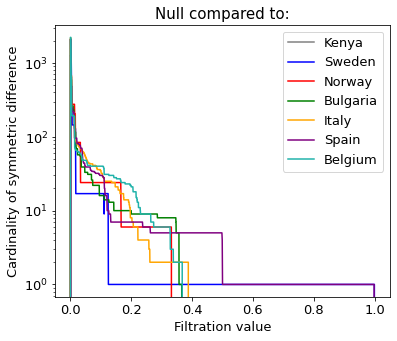

The area under the curve for Null vs Kenya is:  1.7795530674047377e-13
The area under the curve for Null vs Sweden is:  9.777777777777759
The area under the curve for Null vs Norway is:  14.087611607142563
The area under the curve for Null vs Bulgaria is:  13.335288040364079
The area under the curve for Null vs Italy is:  14.939148279380564
The area under the curve for Null vs Spain is:  14.950708072787348
The area under the curve for Null vs Belgium is:  15.605382211691868


In [23]:
null=prob_to_flux(null_cube(9))
g0=null
g1=[dfs[labs.index('Kenya')], dfs[labs.index('Sweden')], dfs[labs.index('Norway')], dfs[labs.index('Bulgaria')],
   dfs[labs.index('Italy')], dfs[labs.index('Spain')], dfs[labs.index('Belgium')]]
label_g0='Null'
labels_g1=['Kenya', 'Sweden', 'Norway','Bulgaria','Italy', 'Spain', 'Belgium']
colors=['gray', 'blue', 'red', 'green', 'orange', 'purple', 'lightseagreen']


WFCCplot(g0, g1, label_g0, labels_g1, colors, log=True, sort=True)

To plot without log scale, we set a smaller range in the x-axis and we do it manually, without the function WFCCplot

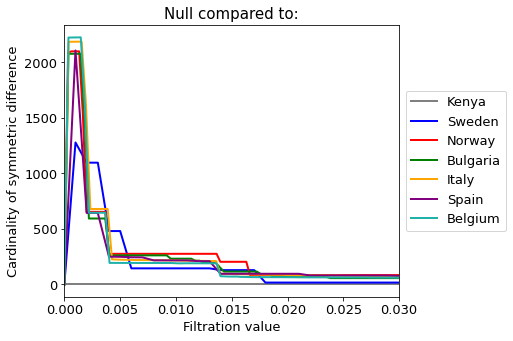

In [24]:
null=prob_to_flux(null_cube(9))

x_val1,y_val1 = WFCC(null, dfs[labs.index('Kenya')])
x_val2,y_val2 = WFCC(null, dfs[labs.index('Sweden')])
x_val3,y_val3 = WFCC(null, dfs[labs.index('Norway')])
x_val4,y_val4 = WFCC(null, dfs[labs.index('Bulgaria')])
x_val5,y_val5 = WFCC(null, dfs[labs.index('Italy')])
x_val6,y_val6 = WFCC(null, dfs[labs.index('Spain')])
x_val7,y_val7 = WFCC(null, dfs[labs.index('Belgium')])

fig,ax = plt.subplots(figsize=(6,5))
plt.plot(x_val1,y_val1, 'gray', linewidth=2)
plt.plot(x_val2,y_val2, 'blue', linewidth=2)
plt.plot(x_val3,y_val3, 'red', linewidth=2)
plt.plot(x_val4,y_val4, 'green', linewidth=2)
plt.plot(x_val5,y_val5, 'orange', linewidth=2)
plt.plot(x_val6,y_val6, 'purple', linewidth=2)
plt.plot(x_val7,y_val7, 'lightseagreen', linewidth=2)
plt.xlim([0, 0.03]) 
plt.title('Null compared to:', fontsize=15)
plt.legend(['Kenya','Sweden', 'Norway', 'Bulgaria', 'Italy', 'Spain', 'Belgium'], fontsize=13, bbox_to_anchor=(1, 0.5), loc="center left")
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)   
plt.savefig('./Data_files_hypercubes/Outputs_github/TB_flux_cut.png')
plt.show()

In [25]:
matrix=[]
for c in labs:
    matrix.append([[area(dfs[labs.index(c)], dfs[labs.index(labs[i])])] for i in range(0, len(labs))])

df=pd.DataFrame(matrix, columns=labs, index=labs)
df.to_csv('./Data_files_hypercubes/Outputs_github/distance_matrix_TB_f.csv')
df

,Belgium,Turkmenistan,Viet Nam,Taiwan,Georgia,Bulgaria,United Kingdom,Brazil,Russia,USA,...,Mali,Oman,Denmark,Sudan,Belarus,Czech Republic,Uzbekistan,Ecuador,Djibouti,India
Belgium,[0.0],[15.79073547955169],[16.19015970680047],[14.620832034003618],[16.222805431445373],[15.428645867301151],[13.25037382768255],[15.301195845157496],[13.88705754664389],[14.959205870884496],...,[15.615005397580209],[15.79073547955169],[15.583737781409896],[14.906546319718032],[15.367700746512446],[16.305352098808275],[14.776474621671502],[15.301207470901135],[15.017866753846924],[14.562587604945428]
Turkmenistan,[15.79073547955169],[0.0],[10.989257812499773],[13.99886067708307],[13.998860677083078],[13.705295796304833],[14.865818699366708],[10.998806423610812],[14.729392590538419],[14.140004557155308],...,[14.979870391176727],[0.0],[13.981228298610919],[13.99886067708307],[15.34153427401508],[12.874271488034015],[16.499532318956035],[10.989257812499769],[12.894228946279181],[10.277868146626698]
Viet Nam,[16.19015970680047],[10.989257812499773],[0.0],[13.998860677083163],[13.998860677083158],[13.288034189029085],[15.711662416741811],[10.998806423610805],[16.52808205773044],[14.14000455715545],...,[14.979870391176632],[10.989257812499773],[13.981228298611057],[13.998860677083163],[17.69939968913152],[12.874271488033854],[17.4984076603693],[10.989257812499787],[12.89422894627933],[12.28368359347642]
Taiwan,[14.620832034003618],[13.99886067708307],[13.998860677083163],[0.0],[10.999999999999899],[13.675080015444566],[14.331455624886404],[9.749999999999913],[15.019385084107284],[11.973255129362396],...,[14.117044004681212],[13.99886067708307],[11.003580729166492],[10.999999999999895],[14.831921846535904],[12.889398056309359],[14.473128287375538],[9.75225151909709],[10.958581008992793],[13.487585977269786]
Georgia,[16.222805431445373],[13.998860677083078],[13.998860677083158],[10.999999999999899],[0.0],[13.15052192988349],[15.11891121122441],[9.749999999999913],[14.968903035137336],[12.979165351044776],...,[13.702250915918416],[13.998860677083078],[11.003580729166488],[14.666666666666455],[15.974097804769192],[5.559507818992958],[14.554900657267309],[9.752251519097085],[10.9585810089928],[12.984096179992067]
Bulgaria,[15.428645867301151],[13.705295796304833],[13.288034189029085],[13.675080015444566],[13.15052192988349],[0.0],[14.352835832412921],[14.021364412526506],[14.62172125082706],[11.35798421867776],...,[11.565583323765429],[13.705295796304833],[12.724042192802836],[12.677939567462479],[15.856851865376548],[13.752072840129555],[15.839970952859604],[14.020063619928537],[11.460890170732274],[12.354604200542568]
United Kingdom,[13.25037382768255],[14.865818699366708],[15.711662416741811],[14.331455624886404],[15.11891121122441],[14.352835832412921],[0.0],[14.293047618859518],[10.455026301805022],[14.29744891386787],...,[14.413442774142668],[14.865818699366708],[15.171346455000494],[14.085469683542504],[15.25021416396652],[15.230333476536465],[14.546601865904341],[14.291456705931928],[13.17773938442019],[13.088338892173299]
Brazil,[15.301195845157496],[10.998806423610812],[10.998806423610805],[9.749999999999913],[9.749999999999913],[14.021364412526506],[14.293047618859518],[0.0],[14.868297892335876],[11.619088588355773],...,[14.981881575374734],[10.998806423610812],[13.989800347221957],[13.999999999999739],[14.883535723655939],[10.338702267376679],[14.456852446718807],[0.009548611111080687],[7.750698572371865],[11.758119682942684]
Russia,[13.88705754664389],[14.729392590538419],[16.52808205773044],[15.019385084107284],[14.968903035137336],[14.62172125082706],[10.455026301805022],[14.868297892335876],[0.0],[14.489213648859515],...,[14.49630663728013],[14.729392590538419],[15.280657025539043],[14.704160448604002],[14.736040040466774],[14.870063142938333],[13.873362257619458],[14.865956923172046],[13.44973001995274],[13.83322612211137]
USA,[14.959205870884496],[14.140004557155308],[14.14000455715545],[11.973255129362396],[12.979165351044776],[11.3579842186

# 3.2 For probability weightings

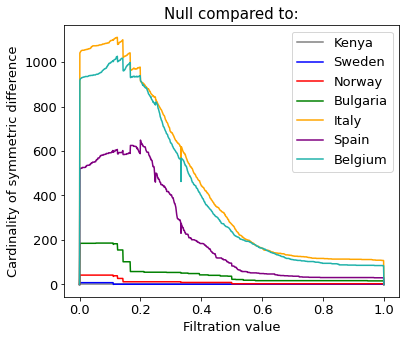

The area under the curve for Null vs Kenya is:  2.877698079828406e-13
The area under the curve for Null vs Sweden is:  1.777777777778165
The area under the curve for Null vs Norway is:  10.963427346018875
The area under the curve for Null vs Bulgaria is:  53.62615633492087
The area under the curve for Null vs Italy is:  455.00489972422076
The area under the curve for Null vs Spain is:  225.78451958150157
The area under the curve for Null vs Belgium is:  415.575224397313


In [26]:
data = pd.read_csv('./Data_files_hypercubes/transition-graphs-pruned-country-TB.csv') 
data = data.drop('Unnamed: 0', axis=1)
labs = list(set(data["label"]))

dfs = []
for lab in labs:
    dfs.append(data[data["label"]==lab].drop(columns=['Flux','label']))

for i,d in enumerate(dfs):
    dfs[i] = list(d.itertuples(index=False, name=None))

null=null_cube(9)
g0=null
g1=[dfs[labs.index('Kenya')], dfs[labs.index('Sweden')], dfs[labs.index('Norway')], dfs[labs.index('Bulgaria')],
   dfs[labs.index('Italy')], dfs[labs.index('Spain')], dfs[labs.index('Belgium')]]
label_g0='Null'
labels_g1=['Kenya', 'Sweden', 'Norway','Bulgaria','Italy', 'Spain', 'Belgium']
colors=['gray', 'blue', 'red', 'green', 'orange', 'purple', 'lightseagreen']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

In [27]:
matrix=[]
for c in labs:
    matrix.append([[area(dfs[labs.index(c)], dfs[labs.index(labs[i])])] for i in range(0, len(labs))])

df=pd.DataFrame(matrix, columns=labs, index=labs)
df.to_csv('./Data_files_hypercubes/Outputs_github/distance_matrix_TB_p.csv') 
df

,Belgium,Turkmenistan,Viet Nam,Taiwan,Georgia,Bulgaria,United Kingdom,Brazil,Russia,USA,...,Mali,Oman,Denmark,Sudan,Belarus,Czech Republic,Uzbekistan,Ecuador,Djibouti,India
Belgium,[0.0],[416.2412400223129],[416.2412400223129],[414.15946963945237],[414.8997243360161],[416.74661038891327],[320.9130526207651],[415.50592618346934],[419.5695078393525],[412.1887697311256],...,[411.66267458833363],[416.2412400223129],[414.8084033871729],[416.4631795689902],[373.60277614344477],[417.3099452662665],[357.35924605827597],[415.5054921556912],[410.58758394624033],[412.11457632518807]
Turkmenistan,[416.2412400223129],[0.0],[1.998046875],[5.499565972222221],[5.499565972222221],[54.292171959920886],[496.73475830138665],[1.9997829861111105],[492.39401825668494],[12.132998063187209],...,[16.200678613994736],[0.0],[5.496308452721633],[5.499565972222221],[297.7116189175513],[8.996561719060256],[252.15492516482126],[1.998046875],[11.639717007733639],[37.40060467708422]
Viet Nam,[416.2412400223129],[1.998046875],[0.0],[5.499565972222222],[5.499565972222222],[53.7202099073392],[496.74514381718524],[1.9997829861111114],[492.5495059155155],[12.13299806318721],...,[16.200678613994736],[1.998046875],[5.496308452721634],[5.499565972222223],[298.20892369435614],[8.996561719060258],[252.25633680754663],[1.998046875000001],[11.63971700773364],[37.40397465823617]
Taiwan,[414.15946963945237],[5.499565972222221],[5.499565972222222],[0.0],[6.5],[53.32891609383511],[497.7703649110385],[4.5],[493.5151372695501],[12.637435170032317],...,[18.57067439950631],[5.499565972222221],[6.500215693221884],[6.5],[296.31665329237336],[10.99598320838615],[249.59057350474637],[4.499782986111112],[12.558547322258493],[38.18504939493973]
Georgia,[414.8997243360161],[5.499565972222221],[5.499565972222222],[6.5],[0.0],[55.29282300158756],[497.990322671588],[4.5],[493.5446421135049],[13.883649109330669],...,[17.451115087805288],[5.499565972222221],[6.500215693221883],[9.0],[298.32136408079293],[4.501123438372338],[249.5905235973799],[4.499782986111112],[12.558547322258493],[35.61200567258194]
Bulgaria,[416.74661038891327],[54.292171959920886],[53.7202099073392],[53.32891609383511],[55.29282300158756],[0.0],[489.4885045905031],[54.29282406190819],[485.199411794351],[44.880355494411276],...,[54.49615102422199],[54.292171959920886],[53.32782814867203],[49.36501747863809],[312.2100688172934],[55.21534818625244],[269.2770554571356],[54.292171959920886],[46.74362812568627],[56.50288968921278]
United Kingdom,[320.9130526207651],[496.73475830138665],[496.74514381718524],[497.7703649110385],[497.990322671588],[489.4885045905031],[0.0],[496.74043725215336],[393.52374275249986],[497.86599597900073],...,[495.790333349873],[496.73475830138665],[497.47302115684107],[497.39531053672016],[452.94573774987623],[498.91191995044335],[468.20712270093225],[496.73891807915834],[496.4039816746874],[490.50708312603103]
Brazil,[415.50592618346934],[1.9997829861111105],[1.9997829861111114],[4.5],[4.5],[54.29282406190819],[496.74043725215336],[0.0],[492.3947235924485],[11.633649755480743],...,[16.201115087805285],[1.9997829861111105],[5.498044563832744],[5.5],[296.708021502673],[8.995982994019707],[250.87013853699378],[0.0017361111111102252],[10.641448752767426],[37.657950545094394]
Russia,[419.5695078393525],[492.39401825668494],[492.5495059155155],[493.5151372695501],[493.5446421135049],[485.199411794351],[393.52374275249986],[492.3947235924485],[0.0],[493.6733847348503],...,[492.2616729552783],[492.39401825668494],[493.29062866775587],[493.53396497616313],[447.5022949048211],[493.8807036230555],[456.5470966700775],[492.3932044943673],[492.4255476301598],[486.87512441691075]
USA,[412.1887697311256],[12.132998063187209],[12.13299806318721],[12.637435170032317],[13.883649109330669],[44.880355494411276],[497.86599597900073],[11.633649755480743],[493.6733847348503],[0.0],...,[12.951233121740271],[12.132998063187209],[11.06839231324614],[7.6393687658128275],[297.1378246345817],[17.881467792631554],[253.363495809

# 4. WFCC comparisons of hypercubes generated by inference algorithms from synthetic data mimicking clinical data

Full synthetic data samples and HyperHMM probability weights:

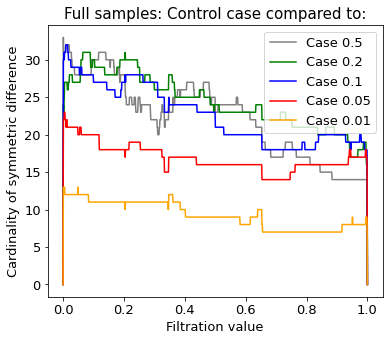

The area under the curve for Full samples: Control case vs Case 0.5 is:  22.318056182583682
The area under the curve for Full samples: Control case vs Case 0.2 is:  24.34556516853358
The area under the curve for Full samples: Control case vs Case 0.1 is:  22.66526151905677
The area under the curve for Full samples: Control case vs Case 0.05 is:  16.946877184067475
The area under the curve for Full samples: Control case vs Case 0.01 is:  9.264304276695118


In [28]:
tree='full1'

control = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_control.txt')
case_01= impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.1.txt')   
case_001 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.01.txt')
case_02 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.2.txt')  
case_005 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.05.txt') 
case_05 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.5.txt')  

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Full samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

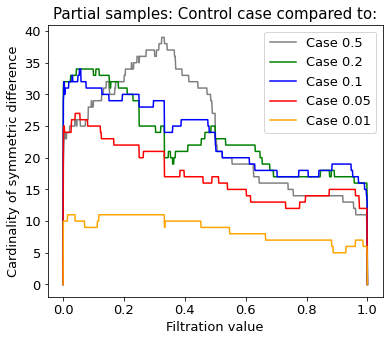

The area under the curve for Partial samples: Control case vs Case 0.5 is:  23.669784642199996
The area under the curve for Partial samples: Control case vs Case 0.2 is:  23.110901372786618
The area under the curve for Partial samples: Control case vs Case 0.1 is:  23.362824372811005
The area under the curve for Partial samples: Control case vs Case 0.05 is:  17.459570198999995
The area under the curve for Partial samples: Control case vs Case 0.01 is:  8.726042631999999


In [29]:
tree='partial1'

control = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_control.txt')
case_01= impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.1.txt')   
case_001 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.01.txt')
case_02 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.2.txt')  
case_005 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.05.txt') 
case_05 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.5.txt')  

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Partial samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

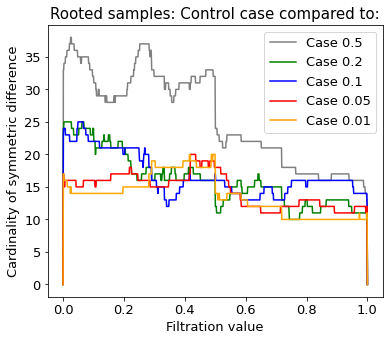

The area under the curve for Rooted samples: Control case vs Case 0.5 is:  25.560527524770258
The area under the curve for Rooted samples: Control case vs Case 0.2 is:  16.115294284399138
The area under the curve for Rooted samples: Control case vs Case 0.1 is:  16.839641381556024
The area under the curve for Rooted samples: Control case vs Case 0.05 is:  14.506096351150761
The area under the curve for Rooted samples: Control case vs Case 0.01 is:  13.67793956560087


In [30]:
tree='rooted1' 

control = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_control.txt')
case_01 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.1.txt')   
case_001 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.01.txt')
case_02 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.2.txt')  
case_005 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.05.txt') 
case_05 = impor('./Data_files_hypercubes/results_synthetic_data/transitions_'+tree+'_case0.5.txt')  

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Rooted samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

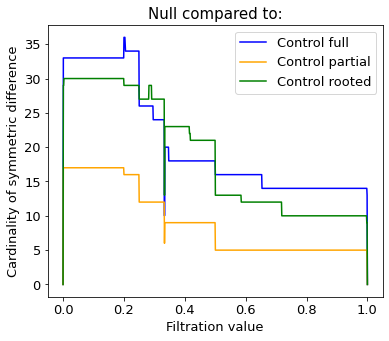

The area under the curve for Null vs Control full is:  20.724007125917026
The area under the curve for Null vs Control partial is:  9.197231952000001
The area under the curve for Null vs Control rooted is:  18.8972686617324


In [31]:
null=null_cube(5)
control_full = impor('./Data_files_hypercubes/results_synthetic_data/transitions_full1_control.txt')
control_partial = impor('./Data_files_hypercubes/results_synthetic_data/transitions_partial1_control.txt')
control_rooted = impor('./Data_files_hypercubes/results_synthetic_data/transitions_rooted1_control.txt')

g0=null
g1=[control_full, control_partial, control_rooted]
label_g0='Null'
labels_g1=['Control full', 'Control partial', 'Control rooted']
colors=['blue', 'orange', 'green']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

Full synthetic data samples and HyperTraPS probability weights:

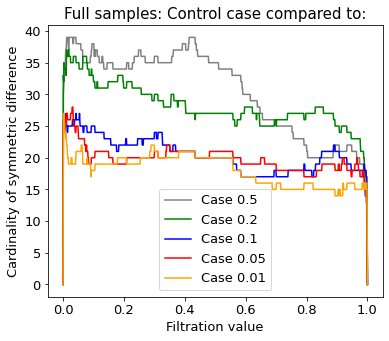

The area under the curve for Full samples: Control case vs Case 0.5 is:  30.467953411864475
The area under the curve for Full samples: Control case vs Case 0.2 is:  28.245177733903486
The area under the curve for Full samples: Control case vs Case 0.1 is:  20.522790151416086
The area under the curve for Full samples: Control case vs Case 0.05 is:  19.839138008189835
The area under the curve for Full samples: Control case vs Case 0.01 is:  18.059023759947202


In [32]:
tree='fullsample1'

control = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/control-trans.txt')
case_01= impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.1-trans.txt')   
case_001 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.01-trans.txt')
case_02 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.2-trans.txt')  
case_005 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.05-trans.txt') 
case_05 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.5-trans.txt') 

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Full samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

Partial synthetic data samples and HyperTraPS probability weights:

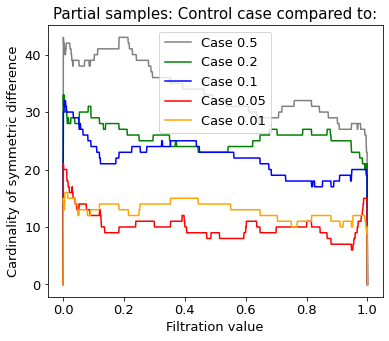

The area under the curve for Partial samples: Control case vs Case 0.5 is:  33.86103233904007
The area under the curve for Partial samples: Control case vs Case 0.2 is:  25.636908353968636
The area under the curve for Partial samples: Control case vs Case 0.1 is:  22.065121668572388
The area under the curve for Partial samples: Control case vs Case 0.05 is:  10.128606032428149
The area under the curve for Partial samples: Control case vs Case 0.01 is:  12.904980597748967


In [33]:
tree='partialsample1'

control = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/control-trans.txt')
case_01= impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.1-trans.txt')   
case_001 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.01-trans.txt')
case_02 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.2-trans.txt')  
case_005 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.05-trans.txt') 
case_05 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.5-trans.txt')

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Partial samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

Rooted synthetic data samples and HyperTraPS probability weights:

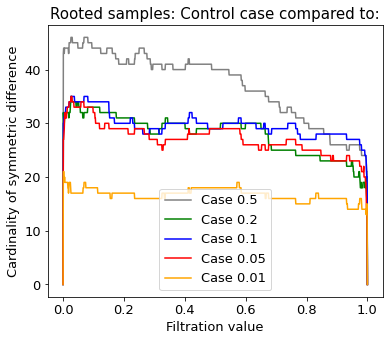

The area under the curve for Rooted samples: Control case vs Case 0.5 is:  37.11793814815241
The area under the curve for Rooted samples: Control case vs Case 0.2 is:  28.03396592793126
The area under the curve for Rooted samples: Control case vs Case 0.1 is:  29.719507090416233
The area under the curve for Rooted samples: Control case vs Case 0.05 is:  27.25223819455485
The area under the curve for Rooted samples: Control case vs Case 0.01 is:  16.703382992693694


In [34]:
tree='rootedSample1'

control = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/control-trans.txt')
case_01= impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.1-trans.txt')   
case_001 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.01-trans.txt')
case_02 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.2-trans.txt')  
case_005 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.05-trans.txt') 
case_05 = impor('./Data_files_hypercubes/hypertrapsTransMatrices/'+tree+'/case0.5-trans.txt')

g0=control
g1=[case_05, case_02, case_01, case_005, case_001]
label_g0='Rooted samples: Control case'
labels_g1=['Case 0.5', 'Case 0.2', 'Case 0.1','Case 0.05','Case 0.01']
colors=['gray', 'green', 'blue', 'red', 'orange']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

Null compared to the control cases for full, partial and rooted synthetic data samples and HyperTraPS probability weights:

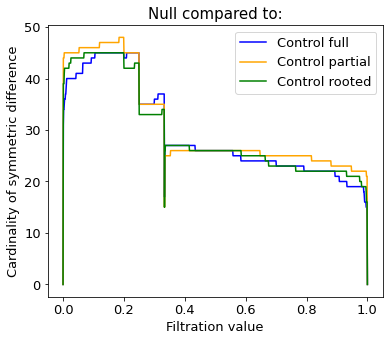

The area under the curve for Null vs Control full is:  29.54852755927783
The area under the curve for Null vs Control partial is:  31.00546694200009
The area under the curve for Null vs Control rooted is:  29.724259392642765


In [35]:
null=null_cube(5)
control_full = impor('./Data_files_hypercubes/hypertrapsTransMatrices/fullsample1/control-trans.txt')
control_partial = impor('./Data_files_hypercubes/hypertrapsTransMatrices/partialsample1/control-trans.txt')
control_rooted = impor('./Data_files_hypercubes/hypertrapsTransMatrices/rootedSample1/control-trans.txt')

g0=null
g1=[control_full, control_partial, control_rooted]
label_g0='Null'
labels_g1=['Control full', 'Control partial', 'Control rooted']
colors=['blue', 'orange', 'green']

WFCCplot(g0, g1, label_g0, labels_g1, colors, log=False)

HyperHMM hypercube compared to HyperTraPS hypercube from the respective control sample cases:

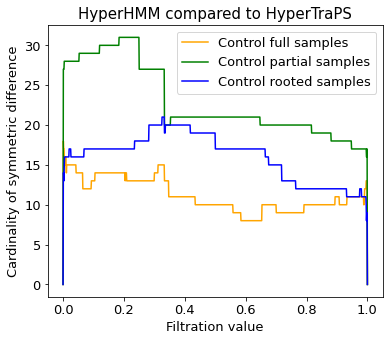

The area under the curve for Control full is:  11.211429662413998
The area under the curve for Control partial is:  22.908144027512
The area under the curve for Control rooted is:  16.028886496798258


In [36]:
full_hyperhmm = impor('./Data_files_hypercubes/results_synthetic_data/transitions_full1_control.txt')
partial_hyperhmm = impor('./Data_files_hypercubes/results_synthetic_data/transitions_partial1_control.txt')
rooted_hyperhmm = impor('./Data_files_hypercubes/results_synthetic_data/transitions_rooted1_control.txt')

full_hypertraps = impor('./Data_files_hypercubes/hypertrapsTransMatrices/fullsample1/control-trans.txt')
partial_hypertraps = impor('./Data_files_hypercubes/hypertrapsTransMatrices/partialsample1/control-trans.txt')
rooted_hypertraps = impor('./Data_files_hypercubes/hypertrapsTransMatrices/rootedSample1/control-trans.txt')

x_val1,y_val1 = WFCC(full_hypertraps,full_hyperhmm)
x_val2,y_val2 = WFCC(partial_hypertraps,partial_hyperhmm)
x_val3,y_val3 = WFCC(rooted_hypertraps,rooted_hyperhmm)

fig,ax = plt.subplots(figsize=(6,5))
plt.plot(x_val1,y_val1, 'orange')
plt.plot(x_val2,y_val2, 'green')
plt.plot(x_val3,y_val3, 'blue')
plt.title('HyperHMM compared to HyperTraPS', fontsize=15)
plt.legend(['Control full samples', 'Control partial samples', 'Control rooted samples'], fontsize=13)
plt.xlabel("Filtration value", fontsize=13)
plt.ylabel("Cardinality of symmetric difference", fontsize=13)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(13)

plt.savefig('./Data_files_hypercubes/Outputs_github/hyperhmm_hypertraps.png')
plt.show()

print('The area under the curve for Control full is: ', area(full_hypertraps,full_hyperhmm))
print('The area under the curve for Control partial is: ', area(partial_hypertraps,partial_hyperhmm))
print('The area under the curve for Control rooted is: ', area(rooted_hypertraps,rooted_hyperhmm))